# EXPECTS:
 `metadata.p` from Process Incoming data about all user sessions.
 `video_consolidated.p` from Processing Incoming data script in the user folder of interest, which is simply the pared down raw openface and eyeratio data that has had an approximate timestamp added based on what we believe from the GoPro.
 `sessions_blink.p` from Processing Incoming data script in the user folder of interest, which is just a list of DFs of glasses blink data, timestamped roughly using the serverTimestamp as a starting point and the uC tick as the main clock source.
 
# OUTPUTS:
 - the goal of this script is to output `best_offset.p` to the user session folder, which is the offset to add to the glasses data to align it to the video.
 
 - it is also to output `video_blink_sessions.p` -- a df of the video data that has been chopped into snippets in which the classifier believes it has succeeded continuously, along with session info and timestamps for each blink within the video.  We typically open this and save it as `vid_meta_data`.

 - it will also output `glasses_all_blink_timestamps_uncorrected.p` to the user folder, which is a list of blink times from the glasses without the offset applied.  These are discovered with our default algorithm set at thresh=0.06, blink_dur_ms=250, lpf_samples=50, dx_lpf_samples=25.
 
We will still need to APPLY a debounce to the video (could change threshold), and our BEST_OFFSET to any glasses data we work with, in the future.

In [29]:
import json
from datetime import datetime , timezone
import time
import numpy as np
import codecs
import struct
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import pycorrelate
import collections
import itertools
from mpl_toolkits import mplot3d
import cv2
import imutils
import os

pd.set_option('display.max_rows', 1000)
%matplotlib inline

### 1. Pick a session to work with!

In [30]:
metadata = pickle.load(open('./cleaned_data/metadata.p', 'rb'))
print('Please Choose a Session to Work With:')
for k in metadata: print(k, end=',  ')

Please Choose a Session to Work With:
david_2,  patrick_1,  patrick_2,  beata_1,  david_3b,  irmandy_1,  juliana_1,  irmandy_2,  patrick_3,  

In [31]:
SESSION = 'beata_1'

let's print some basic summary statistics based on the metadata for this session:

In [32]:
s_meta = metadata[SESSION]

try:
    print(SESSION, 'on', s_meta['date'])
    print('-'*10)
    print(s_meta['glasses_sessions_total_duration_string'], 'hr of glassess data starting at', \
          s_meta['glasses_session_times'][0][0])
    print('%02d:%02d hr of    video data starting at ' % (s_meta['vid_duration_sec'] / 60 // 60, 
           s_meta['vid_duration_sec'] / 60 % 60 )  + s_meta['vid_start'])
    print('-'*10)
    print('glasses sessions:')
    for i in range(len(s_meta['glasses_session_times'])):
        print('session ' + str(i) + ':',s_meta['glasses_session_times'][i][0],'to',\
              s_meta['glasses_session_times'][i][1],'\tduration:%8.2f min' % s_meta['glasses_session_durations_min'][i])
except:
    print('failed to load video analysis file.')

beata_1 on 04/02
----------
08:47 hr of glassess data starting at 04/02/21 12:13:25PM EDT
08:07 hr of    video data starting at 04/02/21 12:16:30PM EDT
----------
glasses sessions:
session 0: 04/02/21 12:13:25PM EDT to 04/02/21 04:39:00PM EDT 	duration:  265.59 min
session 1: 04/02/21 04:54:44PM EDT to 04/02/21 09:16:13PM EDT 	duration:  261.48 min


### Load the Data
...and let's load in the data, and plot what we have just to take a look, by session

In [33]:
#load video data (eyeratio and openface features), 60 Hz (16 ms between samples)
df_vid = pd.read_csv('./cleaned_data/' + SESSION + '/video_consolidated.csv', index_col=0)

#load glasses blink data, 1kHz (1 ms between samples)
blink_sess = pickle.load(open('./cleaned_data/' + SESSION + '/sessions_blink.p', 'rb'))

# give some stupid FutureWarning error thanks to pandas and numpy not being in sync.
# https://stackoverflow.com/questions/48818335/why-pandas-read-csv-issues-this-warning-elementwise-comparison-failed

/usr/local/lib/python3.9/site-packages/numpy/lib/arraysetops.py:583: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [34]:
df_vid['success'].value_counts()

1    1060309
0     694459
Name: success, dtype: int64

In [35]:
blink_sess[0].head()

,timestamp_ms,value
0,1617380005517,253
1,1617380005518,253
2,1617380005519,253
3,1617380005520,127
4,1617380005521,119


In [36]:
def string_to_timestamp_ms(datestring):
    return datetime.strptime(datestring, '%m/%d/%y %I:%M:%S%p %Z').timestamp()*1000

def timestamp_ms_to_string(timestamp):
    local_tz = datetime.now().astimezone().tzinfo
    return datetime.fromtimestamp(timestamp/1000, tz=local_tz).strftime('%m/%d/%y %I:%M:%S%p %Z')

In [37]:
#not going to xcorr, just align with pulses later.  We'll just copy the timestamp_ms to est_timestamp_ms
new_df_vid = df_vid.copy()
new_df_vid['timestamp_ms'] = df_vid['est_timestamp_ms']

## Divide Openface Classifier Results into Sessions and Extract Blinks from the Glasses
It turns out our face extraction from open face doesn't actually work that well, and is pretty spotty.

To better assess how well we're doing with blinks, we need to chop the video data into usable sessions as well-- we'll pull sections where there are contiguous chunks of 'successful' tracking on the faces (with a minimum useful chunk of 200ms by default, and where we tolerate up to 2 consecutive dropped frames that we can interpolate).

We'll use these sections for all future analysis.


In [13]:
# Chop the video into useful sections based on success metric
def print_summary(df_vid, thresh=0.3):
    old_len = len(df_vid)
    df_vids = len(df_vid[df_vid['success'] == 1])
    print('Have',df_vids, 'frames considered successful, (%2.2f%%)' % (100.*df_vids/old_len))    
    df_vidc = len(df_vid[df_vid['confidence'] >= thresh])
    print('Have',df_vidc, 'frames above thresh of',thresh,'(%2.2f%%)' % (100.*df_vidc/old_len))
    
    return old_len, df_vids

def get_sessions_by_success(df_vid_in, min_sess_sec=0.2, tolerate_n_dropped_frames=2):
    sessions = []
    min_sess_len = min_sess_sec * 60 #samples in min_sess_sec is FPS*sec
    prev_tick = 0
    curr_sess = pd.DataFrame()
    
    old_len = len(df_vid_in)
    df_vid = df_vid_in.copy()
    df_vid = df_vid[df_vid['success'] == 1]
    print('Have',len(df_vid), 'frames considered successful, (%2.2f%%)' % (100.*len(df_vid)/old_len))
    
    #iterate over dataframe only where rows have success == 1
    for i, row in df_vid.iterrows():
        #when we skip a row because tracking failed, append current session
        #if it's long enough and start a new session over
        if row['tick_ms'] > (prev_tick + 24.5 + tolerate_n_dropped_frames*100/6.):
            if len(curr_sess) > min_sess_len:
                sessions.append(curr_sess)
            del curr_sess
            curr_sess = pd.DataFrame()
        
        curr_sess = curr_sess.append(row)
        prev_tick = row['tick_ms']        
        
    if len(curr_sess) > min_sess_len: sessions.append(curr_sess)
    
    return sessions


In [14]:
MIN_SEC_SESSION = 0.2
DROP_FRAMES = 2

print_summary(new_df_vid)
print('-'*20)
print('USING SUCCESSFUL BY OPENFACE STANDARD')
print('-'*20)
vid_sess = get_sessions_by_success(new_df_vid, 
                                   min_sess_sec=MIN_SEC_SESSION, 
                                   tolerate_n_dropped_frames=DROP_FRAMES)

print('found',len(vid_sess),'sessions.')

Have 1060309 frames considered successful, (60.42%)
Have 1110518 frames above thresh of 0.3 (63.29%)
--------------------
USING SUCCESSFUL BY OPENFACE STANDARD
--------------------
Have 1060309 frames considered successful, (60.42%)
found 1932 sessions.


#### Save the data

Given our time aligned video data and our chunks of reasonable tracking, we can save some metadata about what chunks we have and how many blinks we detect in each chunk.  This is what we'll use for ground truth.

In [15]:
def count_rising_edges(sess, column):
    #assuming a 1/0 signal, counts transitions to 1.  Starting at 1
    #counts as a transition.
    prev_row, count = 0, 0
    for i,row in sess.iterrows():
        if row[column] == 1 and prev_row == 0: count += 1
        prev_row = row[column]    
    return count

def count_rising_edges_list(values):
    #assuming a 1/0 signal, counts transitions to 1.  Starting at 1
    #counts as a transition.
    prev_row, count = 0, 0
    for v in values:
        if v == 1 and prev_row == 0: count += 1
        prev_row = v    
    return count

def rising_edge_times(sess, column, timecolumn):
    #assuming a 1/0 signal, returns transition times. Starting at 1
    #counts as a transition.
    prev_row, transitions = 0, []
    for i,row in sess.iterrows():
        if row[column] == 1 and prev_row == 0: 
            transitions.append(row[timecolumn])
        prev_row = row[column]    
    return transitions

In [16]:
total, successful = print_summary(df_vid, thresh=0.3)

vid_meta_data = {}
vid_meta_data['total_frames'] = total
vid_meta_data['successful_frames'] = successful
vid_meta_data['percent_successful'] = 100.*successful/total
vid_meta_data['total_duration_sec'] = total/60.
vid_meta_data['session_min_sec'] = MIN_SEC_SESSION
vid_meta_data['session_drop_frames'] = DROP_FRAMES
vid_meta_data['num_sessions'] = len(vid_sess)
vid_meta_data['session_times'] = [[s['timestamp_ms'].iloc[0], s['timestamp_ms'].iloc[-1]] for s in vid_sess]
vid_meta_data['duration_sessions_sec'] = [(s['timestamp_ms'].iloc[-1] - s['timestamp_ms'].iloc[0])/1000. for s in vid_sess]
vid_meta_data['session_total_sec'] = sum(vid_meta_data['duration_sessions_sec'])
vid_meta_data['blinks_per_session'] = [count_rising_edges(s, 'AU45_c') for s in vid_sess]
vid_meta_data['blink_timestamps_per_session'] = [rising_edge_times(s, 'AU45_c', 'timestamp_ms') for s in vid_sess]
vid_meta_data['total_blinks'] = sum(vid_meta_data['blinks_per_session'])
vid_meta_data['blinks_per_sec'] = vid_meta_data['total_blinks'] / vid_meta_data['session_total_sec']

print('Measured', vid_meta_data['total_blinks'], 'blinks.  That gives %.2f blinks/min' % (60.*vid_meta_data['blinks_per_sec']))

pickle.dump(vid_meta_data, open( './cleaned_data/' + SESSION + '/video_blink_sessions.p', "wb" ))

Have 1060309 frames considered successful, (60.42%)
Have 1110518 frames above thresh of 0.3 (63.29%)
Measured 6300 blinks.  That gives 21.55 blinks/min


In [39]:
vid_meta_data = pickle.load(open( './cleaned_data/' + SESSION + '/video_blink_sessions.p', "rb" ))

So now we have the blinks arranged in blink sessions with start/end times that we 'trust', timestamps for each blink within those sections, and 
counts for number of blinks in each session, and duration of each session.  we can use vid_meta_data from now on.

We could need to debounce the extracted video data.  The timing also is not aligned automatically.

For glasses blink data, we have blink_sess which is not processed.

## Let's pull out all glasses blinks based on our baseline algorithm and store them as well

In [44]:
def grab_blinks(blink_sess, thresh=0.06, blink_dur_ms=175, lpf_samples=50, dx_lpf_samples=25, reverse=False):
    #get array of (1)timestamps of blinks, (2) [peak close velocity, peak open velocity], (3) duration
    
    def moving_average(x, w):
        return np.convolve(x, np.ones(w), 'same') / w
    
    #step 1: LPF input, take derivative, LPF derivative
    smooth_input = moving_average(blink_sess['value'], lpf_samples)
    dx = np.append([np.nan], np.diff(smooth_input))
    smooth_dx = moving_average(dx, dx_lpf_samples)
    df_results = pd.DataFrame({'timestamp_ms':blink_sess['timestamp_ms'], 'dx':smooth_dx})
    
    #step 2, apply threshold
    if reverse:
        decision = (smooth_dx > thresh)
    else:
        decision = (smooth_dx < -1*thresh)

    plt.plot(df_results['timestamp_ms'], df_results['dx'])
    plt.plot(df_results['timestamp_ms'], decision)
    plt.show()
    #step 3, use this thresholded value to decide if we are blinking subject to debounce.
    #grab the blink time. within the bounds of the blink, find the duration and peak velocities using the derivative.
    df_blinks = pd.DataFrame()
    samples_per_blink = int(blink_dur_ms)  # happen to sample at 1kHz so 1 sample == 1 ms
    samples_blink_debounce = int(samples_per_blink/2)
    i, blinkrow = 0, {}
    while i<len(decision):
        if decision[i]: #we have a blink
            blinkrow['timestamp_ms'] = df_results['timestamp_ms'].iloc[i] #timestamp of this blink
            
            df_thisblink = df_results.iloc[i:i+samples_per_blink] #grab the data associated with this blink
            if reverse:
                max_close = df_thisblink[df_thisblink['dx'] == df_thisblink['dx'].max()]
                max_open  = df_thisblink[df_thisblink['dx'] == df_thisblink['dx'].min()]
            else:
                max_close = df_thisblink[df_thisblink['dx'] == df_thisblink['dx'].min()]
                max_open  = df_thisblink[df_thisblink['dx'] == df_thisblink['dx'].max()]
            
            blinkrow['vel_close'] = abs(max_close['dx'].iloc[0]) #peak close velocity
            blinkrow['vel_open']  = abs(max_open['dx'].iloc[-1]) #peak open velocity
            blinkrow['duration_ms'] = max_open['timestamp_ms'].iloc[-1] - max_close['timestamp_ms'].iloc[0] #duration
            
            df_blinks = df_blinks.append(blinkrow, ignore_index=True)
            i += samples_blink_debounce #move ahead debounce samples before checking for blinks again
        else: i += 1
            
    return df_blinks

def get_all_blink_sessions(blink_sessions, thresh=0.06, blink_dur_ms=250, lpf_samples=50, dx_lpf_samples=25, reverse=False):
    
    df_result = pd.DataFrame()
    for sess in blink_sessions:
        df_blinks = grab_blinks(sess,
                                thresh=thresh, 
                                blink_dur_ms=blink_dur_ms, 
                                lpf_samples=lpf_samples, 
                                dx_lpf_samples=dx_lpf_samples, 
                                reverse=reverse)
        df_result = df_result.append(df_blinks, ignore_index=True)
        
    return df_result

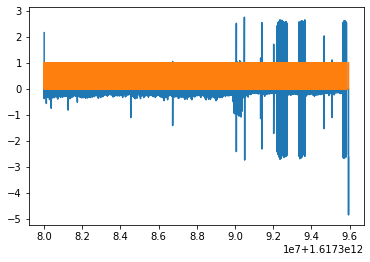

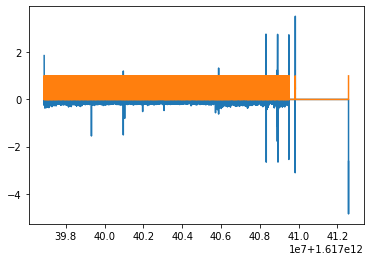

In [45]:
df_all_glasses_blinks = get_all_blink_sessions(blink_sess)
pickle.dump(df_all_glasses_blinks, open( './cleaned_data/' + SESSION + '/glasses_all_blink_timestamps_uncorrected.p', "wb" ))

In [46]:
df_all_glasses_blinks = pickle.load(open( './cleaned_data/' + SESSION + '/glasses_all_blink_timestamps_uncorrected.p', "rb" ))

In [47]:
#STREAM A SECTION OF VIDEO WITH A DF OVERLAY OF BLINK TIMES

#show video with overlay of a df with timestamps and an offset so we can manually check blink alignment of both the video DF and our video analysis DF
#above we were aligning the video to the glasses; here we'll align our glasses to the video

#lets just do everything in minutes like we were doing in the above
def stream_with_blink_data_overlay(video_filename, blinktime_list_ms, video_start_timestamp_ms, start_time_min, end_time_min, ms_offset=0, fps=59.94, plot_blinksig=False):

    start_frame = int(start_time_min*60*fps)
    end_frame = int(end_time_min*60*fps)
    
    print(start_frame)
    print(end_frame)
    #blink times to frame list:
    stream_starttime_sec = video_start_timestamp_ms/1000. + start_frame/fps
    blink_duration_sec = 0.2 # how long to show it on screen; make sure if it's a new blink we put a 0 in between
    frame_duration_sec = 1/fps #time between frames in sec
    
    #make array of proper length full of zeros
    blink_sig = np.zeros(end_frame-start_frame)
    
    #whenever we have a blink, put ones in there for blink_dur frames.  Make sure the sample before that blink is zero
    for btime in blinktime_list_ms:
        btime_sec_stream = ((btime+ms_offset)/1000.)-stream_starttime_sec
        if -blink_duration_sec < btime_sec_stream < (end_time_min-start_time_min)*60:
            bframe = int(btime_sec_stream*fps)
            print((btime/1000), bframe)
            
            if bframe < 1:
                blink_sig[0:bframe+int(blink_duration_sec*fps)] = 1
            elif bframe+int(blink_duration_sec*fps) > len(blink_sig):
                blink_sig[bframe-1] = 0  
                blink_sig[bframe:-1] = 1
            else:
                blink_sig[bframe-1] = 0  
                blink_sig[bframe:bframe+int(blink_duration_sec*fps)] = 1
                
    if plot_blinksig:
        fig, ax = plt.subplots(figsize=(20,4))
        plt.plot(blink_sig)
        plt.title('blink signal') 
        plt.show()
     
    WINDOW_NAME = 'blink_window'
    cv2.namedWindow(WINDOW_NAME, cv2.WINDOW_AUTOSIZE)
    cv2.startWindowThread()

    vs = cv2.VideoCapture(video_filename)
    vs.set(cv2.CAP_PROP_POS_FRAMES, start_frame-1)
    time.sleep(1.0)
    

    prev_frame, blink_count = 0, 0
    for fno in range(0, end_frame-start_frame):
        _, frame = vs.read()  
        #frame = imutils.resize(frame, width=480)
    
        if not fno:
            os.system('''/usr/bin/osascript -e 'tell app "Finder" to set frontmost of process "Python" to true' ''') 
    
        if blink_sig[fno] and not prev_frame:
            blink_count += 1
            
        
        cv2.putText(frame, "COUNT: %d"%(blink_count), (20, 30),
            cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
       
        if blink_sig[fno]:
            cv2.putText(frame, "BLINKING NOW!!!!!!", (300, 30),
                cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)

        # show the frame
        cv2.imshow(WINDOW_NAME, frame)
        key = cv2.waitKey(1) & 0xFF

        prev_frame = blink_sig[fno]
        
        # if the `q` key was pressed, break from the loop
        if key == ord("q"):
            break

    # do a bit of cleanup
    cv2.waitKey(1)
    cv2.destroyAllWindows()
    cv2.waitKey(1)
    
    os.system('''/usr/bin/osascript -e 'tell app "Finder" to set frontmost of process "Chrome" to true' ''') 
    
    
def try_offsets_and_overlay(video_filename, blinktime_list_ms, video_start_timestamp_ms, start_time_min, end_time_min):
    ms_offset = int(input('enter a MS offset:'))
    first = True
    while True:
        stream_with_blink_data_overlay(video_filename, 
                               blinktime_list_ms, 
                               video_start_timestamp_ms, 
                               start_time_min, 
                               end_time_min,
                               ms_offset,
                               plot_blinksig=first)
        first = False
        
        cont = input('enter new MS offset or q to exit')
        
        if str(cont) == 'q':
            print('best offset = ', ms_offset)
            return ms_offset
        
        ms_offset = int(cont)

In [49]:
#hand labeled
hand_timestamps = [1617390698453.3333, 1617390699886.6667, 1617390700670.0, 1617390701586.6667, 1617390705370.0, 
                         1617390705786.6667, 1617390706603.3333, 1617390708670.0, 1617390708886.6667, 1617390713570.0, 
                         1617390714370.0, 1617390715153.3333, 1617390717970.0, 1617390721920.0, 1617390723653.3333, 
                         1617390725353.3333, 1617390727203.3333, 1617390731653.3333, 1617390734586.6667, 1617390738236.6667, 
                         1617390744370.0, 1617390746070.0, 1617390748453.3333, 1617390752236.6667, 1617390754636.6667, 
                         1617390757336.6667, 1617390760053.3333, 1617390762603.3333, 1617390765903.3333, 1617390767186.6667, 
                         1617390770620.0, 1617390775886.6667, 1617390776986.6667, 1617390781986.6667, 1617390785753.3333, 1617390788270.0, 1617390790086.6667]



optimal_offset = try_offsets_and_overlay('/Volumes/ExtDrive_(ResEnv)/data_cap_val_2/' + SESSION + '/video_1.mp4',  #/openface/video_adobe.mp4 /video_crop_1.mp4
                           hand_timestamps,                   #list of blink times in clip
                           vid_start_timestamp,                                                       #start timestamp of video
                           (hand_timestamps[0]-400-vid_start_timestamp)/60000.0, #start timestamp of clip we're watching in min from start
                           (hand_timestamps[-1]+400-vid_start_timestamp)/60000.0) #end timestamp of clip we're watching in min from start
                           #(vid_meta_data['session_times'][SESS_NUM][1]-vid_start_timestamp)/60000.0) #end timestamp of clip we're watching in min from start


"\noptimal_offset = try_offsets_and_overlay('/Volumes/ExtDrive_(ResEnv)/data_cap_val_2/' + SESSION + '/video_1.mp4',  #/openface/video_adobe.mp4 /video_crop_1.mp4\n                           hand_timestamps,                   #list of blink times in clip\n                           vid_start_timestamp,                                                       #start timestamp of video\n                           (hand_timestamps[0]-400-vid_start_timestamp)/60000.0, #start timestamp of clip we're watching in min from start\n                           (hand_timestamps[-1]+400-vid_start_timestamp)/60000.0) #end timestamp of clip we're watching in min from start\n                           #(vid_meta_data['session_times'][SESS_NUM][1]-vid_start_timestamp)/60000.0) #end timestamp of clip we're watching in min from start\n"

enter a MS offset: -50120


629852
635393
1617390748.599 26
1617390749.29 67
1617390749.986 109
1617390750.734 154
1617390751.313 188
1617390751.671 210
1617390755.484 438
1617390755.808 458
1617390756.701 511
1617390758.835 639
1617390759.105 655
1617390763.548 922
1617390764.422 974
1617390764.769 995
1617390765.178 1019
1617390765.303 1027
1617390765.767 1055
1617390766.388 1092
1617390767.188 1140
1617390768.094 1194
1617390769.795 1296
1617390772.092 1434
1617390773.813 1537
1617390775.478 1637
1617390777.184 1739
1617390777.309 1747
1617390781.801 2016
1617390782.185 2039
1617390783.262 2103
1617390784.769 2194
1617390785.482 2236
1617390785.86 2259
1617390787.182 2338
1617390788.295 2405
1617390788.847 2438
1617390790.78 2554
1617390791.369 2589
1617390791.622 2605
1617390792.185 2638
1617390794.56 2781
1617390796.238 2881
1617390797.188 2938
1617390798.668 3027
1617390799.776 3093
1617390802.469 3255
1617390804.836 3397
1617390807.575 3561
1617390812.191 3837
1617390812.828 3876
1617390816.067 4070
161739

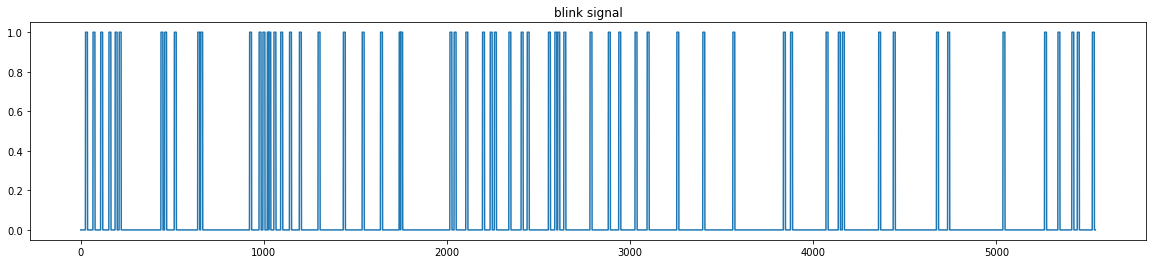

enter new MS offset or q to exit q


best offset =  -50120


In [81]:
#now glasses data
optimal_offset = try_offsets_and_overlay('/Volumes/ExtDrive_(ResEnv)/data_cap_val_2/' + SESSION + '/video_1.mp4',  #/openface/video_adobe.mp4 /video_crop_1.mp4
                           df_all_glasses_blinks['timestamp_ms'].values,                              #list of blink times in clip
                           vid_start_timestamp,                                                       #start timestamp of video
                           (hand_timestamps[0]-400-vid_start_timestamp)/60000.0, #start timestamp of clip we're watching in min from start
                           (hand_timestamps[-1]+400-vid_start_timestamp)/60000.0) #end timestamp of clip we're watching in min from start
                           #(vid_meta_data['session_times'][SESS_NUM][1]-vid_start_timestamp)/60000.0) #end timestamp of clip we're watching in min from start


### there is a clear alignment between the two above; we need to move the glasses data earlier in time by about 300 frames, or 200/59.94 =  -4 sec (4250ms)

Let's bound our search between -4 and -5 ms offset applied to the glasses df

In [52]:
#now lets align and retest
flatten = lambda t: [item for sublist in t for item in sublist]

def debounce_data(list_of_times, debounce_dur_ms=150):
    
    indices_to_remove = []
    for i in range(1, len(list_of_times)):
        if list_of_times[i-1] >= list_of_times[i] - debounce_dur_ms:
            indices_to_remove.append(i)

    for index in sorted(indices_to_remove, reverse=True):
        del list_of_times[index]
        
    return list_of_times

def chop_times(list_of_times, min_time, max_time):
    return [c for c in list_of_times if min_time < c < max_time]

In [69]:
def get_optimal_offset_larger_error(g_times, v_times, offset_lower_ms, offset_higher_ms, step_ms, thresh_ms): 

    #seems to be fine, need to discount all video blinks not in glasses range, but in from both sides by 2*s_meta['start_error_sec']*1000
    #df_blink only has a few blinks in it-- short session?  Need all blinks

    g_times = chop_times(g_times, v_times[0]+offset_lower_ms, v_times[-1]+offset_higher_ms)
        
    errors = []
    #move through all offsets we can think about, brute force
    best_offset, min_error = None, None 
    for offset in range(offset_lower_ms, offset_higher_ms, step_ms):
        offset_error = 0
        curr_index = 0
        for vtime in v_times:
            while g_times[curr_index]+offset <= vtime:
                if curr_index==(len(g_times)-1): break
                curr_index+=1
            
            if curr_index == 0:
                curr_err = abs((g_times[0]+offset)-vtime)
            elif curr_index == len(g_times)-1:
                curr_err = min(abs((g_times[curr_index]+offset)-vtime), abs((g_times[curr_index-1]+offset)-vtime))   
            else:
                curr_err = min(vtime-(g_times[curr_index-1]+offset), (g_times[curr_index]+offset)-vtime)

            if curr_err < thresh_ms: curr_err = 0
            offset_error += curr_err
            #print('curr, accum err:',curr_err, offset_error)
        
        errors.append(offset_error)
        
        if best_offset is None:
            best_offset = [offset]
            min_error = offset_error
        elif offset_error < min_error:
            #print('new min!')
            best_offset = [offset]
            min_error = offset_error
            #print(min_error, best_offset)
        elif offset_error == min_error:
            print('shared min!')
            best_offset.append(offset)
            print(min_error, best_offset)
        
    fig, ax = plt.subplots(figsize=(20,4))
    plt.plot(range(offset_lower_ms, offset_higher_ms, step_ms), errors)
    plt.title('xcorr of offsets') 
    plt.show()    
    
    return best_offset

In [ ]:
#try with hand_labeled
MIN_ALIGN_ERROR = -52000
MAX_ALIGN_ERROR = -49000

#just pull g_times into a list
g_times = df_all_glasses_blinks['timestamp_ms'].values
best_offset = get_optimal_offset_larger_error(g_times, hand_timestamps, MIN_ALIGN_ERROR, MAX_ALIGN_ERROR, 5, 150)
print('optimal offset with thresh of 75 ms:')
print(best_offset)

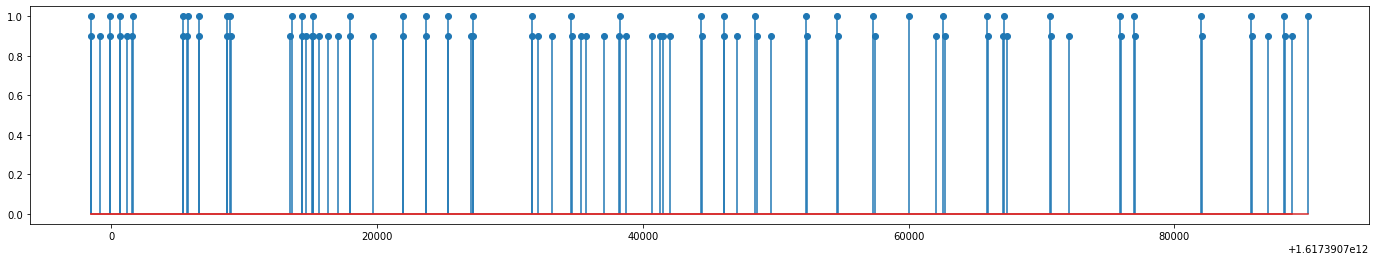

In [77]:
best_offset = -50120

g_times = df_all_glasses_blinks['timestamp_ms'].values
g_times_show = chop_times(g_times, hand_timestamps[0]-best_offset, hand_timestamps[-1]-best_offset)
g_times_show = [g+best_offset for g in g_times_show]

fig, ax = plt.subplots(figsize=(24,4))
plt.stem(hand_timestamps, np.ones(len(hand_timestamps)))
plt.stem(g_times_show, 0.9*np.ones(len(g_times_show)))
plt.show()


In [ ]:
pickle.dump(best_offset[0], open( './cleaned_data/' + SESSION + '/best_offset.p', "wb" ))

In [ ]:
pickle.dump(-50120, open( './cleaned_data/' + SESSION + '/best_offset.p', "wb" ))